In [1]:
import cv2
import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def flow_vector(flow, spacing, margin, minlength):
    """Parameters:
    input
    flow: motion vectors 3D-array
    spacing: pixel spacing of the flow
    margin: pixel margins of the flow
    minlength: minimum pixels to leave as flow
    output
    x: x coord 1D-array
    y: y coord 1D-array
    u: x direction flow vector 2D-array
    v: y direction flow vector 2D-array
    """
    h, w, _ = flow.shape

    x = np.arange(margin, w - margin, spacing, dtype=np.int64)
    y = np.arange(margin, h - margin, spacing, dtype=np.int64)

    mesh_flow = flow[np.ix_(y, x)]
    mag, _ = cv2.cartToPolar(mesh_flow[..., 0], mesh_flow[..., 1])
    mag = mag
    mesh_flow[mag < minlength] = np.nan  # minlength以下をnanに置換

    u = mesh_flow[..., 0] * 500.0
    v = mesh_flow[..., 1] * 500.0

    return x, y, u, v

def adjust_ang(ang_min, ang_max):
    """Parameters
    input
    ang_min: start angle of degree
    ang_max: end angle of degree
    output
    unique_ang_min: angle after conversion to unique `ang_min`
    unique_ang_max: angle after conversion to unique `ang_max`
    """
    unique_ang_min = ang_min
    unique_ang_max = ang_max
    unique_ang_min %= 360
    unique_ang_max %= 360
    if unique_ang_min >= unique_ang_max:
        unique_ang_max += 360
    return unique_ang_min, unique_ang_max

def any_angle_only(mag, ang, ang_min, ang_max):
    """
    input
    mag: `cv2.cartToPolar` method `mag` reuslts
    ang: `cv2.cartToPolar` method `ang` reuslts
    ang_min: start angle of degree after `adjust_ang` function
    ang_max: end angle of degree after `adjust_ang` function
    output
    any_mag: array of replace any out of range `ang` with nan
    any_ang: array of replace any out of range `mag` with nan
    description
    Replace any out of range `mag` and `ang` with nan.
    """
    any_mag = np.copy(mag)
    any_ang = np.copy(ang)
    ang_min %= 360
    ang_max %= 360
    if ang_min < ang_max:
        any_mag[(ang < ang_min) | (ang_max < ang)] = np.nan
        any_ang[(ang < ang_min) | (ang_max < ang)] = np.nan
    else:
        any_mag[(ang_max < ang) & (ang < ang_min)] = np.nan
        any_ang[(ang_max < ang) & (ang < ang_min)] = np.nan
        any_ang[ang <= ang_max] += 360
    return any_mag, any_ang

def hsv_cmap(ang_min, ang_max, size):
    """
    input
    ang_min: start angle of degree after `adjust_ang` function
    ang_max: end angle of degree after `adjust_ang` function
    size: map px size
    output
    hsv_cmap_rgb: HSV color map in radial vector flow
    x, y, u, v: radial vector flow value
    x: x coord 1D-array
    y: y coord 1D-array
    u: x direction flow vector 2D-array
    v: y direction flow vector 2D-array
    description
    Create a normalized hsv colormap between `ang_min` and `ang_max`.
    """
    # 放射状に広がるベクトル場の生成
    half = size // 2
    x = np.arange(-half, half+1, 1, dtype=np.float64)
    y = np.arange(-half, half+1, 1, dtype=np.float64)
    u, v = np.meshgrid(x, y)

    # HSV色空間の配列に入れる
    hsv = np.zeros((len(y), len(x), 3), dtype='uint8')
    mag, ang = cv2.cartToPolar(u, v, angleInDegrees=True)
    any_mag, any_ang = any_angle_only(mag, ang, ang_min, ang_max)
    hsv[..., 0] = 180*(any_ang - ang_min) / (ang_max - ang_min)
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)
    hsv_cmap_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return hsv_cmap_rgb, x, y, u, v

def flow_warp(x,
              flow,
              interpolation='bilinear',
              padding_mode='border',
              align_corners=True):
    """Warp an image or a feature map with optical flow.

    Args:
        x (Tensor): Tensor with size (n, c, h, w).
        flow (Tensor): Tensor with size (n, h, w, 2). The last dimension is
            a two-channel, denoting the width and height relative offsets.
            Note that the values are not normalized to [-1, 1].
        interpolation (str): Interpolation mode: 'nearest' or 'bilinear'.
            Default: 'bilinear'.
        padding_mode (str): Padding mode: 'zeros' or 'border' or 'reflection'.
            Default: 'zeros'.
        align_corners (bool): Whether align corners. Default: True.

    Returns:
        Tensor: Warped image or feature map.
    """
    if x.size()[-2:] != flow.size()[1:3]:
        raise ValueError(f'The spatial sizes of input ({x.size()[-2:]}) and '
                         f'flow ({flow.size()[1:3]}) are not the same.')
    _, _, h, w = x.size()
    # create mesh grid
    device = flow.device
    grid_y, grid_x = torch.meshgrid(
        torch.arange(0, h, device=device, dtype=x.dtype),
        torch.arange(0, w, device=device, dtype=x.dtype))
    grid = torch.stack((grid_x, grid_y), 2)  # h, w, 2
    grid.requires_grad = False

    grid_flow = grid + flow
    # scale grid_flow to [-1,1]
    grid_flow_x = 2.0 * grid_flow[:, :, :, 0] / max(w - 1, 1) - 1.0
    grid_flow_y = 2.0 * grid_flow[:, :, :, 1] / max(h - 1, 1) - 1.0
    grid_flow = torch.stack((grid_flow_x, grid_flow_y), dim=3)
    output = F.grid_sample(
        x,
        grid_flow,
        mode=interpolation,
        padding_mode=padding_mode,
        align_corners=align_corners)
    return output


In [3]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Arrow
from PIL import Image, ImageDraw

from einops import rearrange
import torchvision.transforms as transforms
# from DCNv2_latest.dcn_v2 import DCNv2
from PIL import Image



class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_first"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class ElementScale(nn.Module):
    """A learnable element-wise scaler."""

    def __init__(self, embed_dims, init_value=0., requires_grad=True):
        super(ElementScale, self).__init__()
        self.scale = nn.Parameter(
            init_value * torch.ones((1, embed_dims, 1, 1)),
            requires_grad=requires_grad
        )

    def forward(self, x):
        return x * self.scale

def ones(tensor):
    if tensor is not None:
        tensor.data.fill_(0.5)

def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0.0)

def batch_index_select(x, idx):
    if len(x.size()) == 3:
        B, N, C = x.size()
        N_new = idx.size(1)
        offset = torch.arange(B, dtype=torch.long, device=x.device).view(B, 1) * N
        idx = idx + offset
        out = x.reshape(B*N, C)[idx.reshape(-1)].reshape(B, N_new, C)
        return out
    elif len(x.size()) == 2:
        B, N = x.size()
        N_new = idx.size(1)
        offset = torch.arange(B, dtype=torch.long, device=x.device).view(B, 1) * N
        idx = idx + offset
        out = x.reshape(B*N)[idx.reshape(-1)].reshape(B, N_new)
        return out
    elif len(x.size()) == 4:
        B, C, H, W = x.size()
        N_new = idx.size(1)
        offset = torch.arange(B, dtype=torch.long, device=x.device).view(B, 1, 1, 1) * H * W
        idx = idx.view(B, N_new, 1, 1) + offset
        out = x.view(B * H * W, C)[idx.view(-1)].view(B, N_new, C, H, W)
        return out
    else:
        raise NotImplementedError

def batch_index_fill(x, x1, x2, idx1, idx2):
    B, N, C = x.size()
    B, N1, C = x1.size()
    B, N2, C = x2.size()

    offset = torch.arange(B, dtype=torch.long, device=x.device).view(B, 1)
    idx1 = idx1 + offset * N
    idx2 = idx2 + offset * N

    x = x.reshape(B*N, C)

    x[idx1.reshape(-1)] = x1.reshape(B*N1, C)
    x[idx2.reshape(-1)] = x2.reshape(B*N2, C)

    x = x.reshape(B, N, C)
    return x


class PredictorLG(nn.Module):
    """ Importance Score Predictor
    """
    def __init__(self, dim, window_size=8, k=4):
        super().__init__()

        self.window_size = window_size

        cdim = dim + k
        embed_dim = window_size**2

        self.in_conv = nn.Sequential(
            nn.Conv2d(cdim, cdim//4, 1),
            LayerNorm(cdim//4),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

        self.out_offsets = nn.Sequential(
            nn.Conv2d(cdim//4, cdim//8, 1),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(cdim//8, 2, 1),
        )

        self.out_mask = nn.Sequential(
            nn.Linear(embed_dim, window_size),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(window_size, 2),
            nn.Softmax(dim=-1)
        )

        self.out_CA = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(cdim//4, dim, 1),
            nn.Sigmoid(),
        )

        self.out_SA = nn.Sequential(
            nn.Conv2d(cdim//4, 1, 3, 1, 1),
            nn.Sigmoid(),
        )        


    def forward(self, input_x, mask=None, ratio=0.5, train_mode=False):

        x = self.in_conv(input_x)

        offsets = self.out_offsets(x)
        offsets = offsets.tanh().mul(8.0)

        ca = self.out_CA(x)
        sa = self.out_SA(x)
        
        x = torch.mean(x, keepdim=True, dim=1) 

        x = rearrange(x,'b c (h dh) (w dw) -> b (h w) (dh dw c)', dh=self.window_size, dw=self.window_size)
        B, N, C = x.size()

        pred_score = self.out_mask(x)
        mask = F.gumbel_softmax(pred_score, hard=True, dim=2)[:, :, 0:1]

        if self.training or train_mode:
            return mask, offsets, ca, sa
        else:
            ratio = 1.0
            score = pred_score[:, : , 0]
            B, N = score.shape
            r = torch.mean(mask,dim=(0,1))
            num_keep_node = min(N,int(N * r * ratio))
            idx = torch.argsort(score, dim=1, descending=True)
            idx1 = idx[:, :num_keep_node]
            idx2 = idx[:, num_keep_node:]
            return [idx1, idx2], offsets, ca, sa

class PostNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.norm(self.fn(x) + x)

class CAMixer(nn.Module):
    def __init__(self, dim, window_size=8, bias=True, is_deformable=True, ratio=0.5):
        super().__init__()    

        self.dim = dim
        self.window_size = window_size
        self.is_deformable = is_deformable
        self.ratio = ratio
        k = 3
        d = 2

        self.project_v = nn.Conv2d(dim, dim, 1, 1, 0, bias = bias)
        self.project_q = nn.Linear(dim, dim, bias = bias)
        self.project_k = nn.Linear(dim, dim, bias = bias)

        # self.sim_attn = nn.Conv2d(dim, dim, kernel_size=3, bias=True, groups=dim, padding=1)
        
        # Conv
        # self.conv_sptial = nn.Conv2d(dim, dim, kernel_size=3, bias=True, groups=dim, padding=1)
        self.conv_sptial = nn.Sequential(
            nn.Conv2d(dim, dim, k, padding=k//2, groups=dim),
            nn.Conv2d(dim, dim, k, stride=1, padding=((k//2)*d), groups=dim, dilation=d))        
        self.project_out = nn.Conv2d(dim, dim, 1, 1, 0, bias = bias)

        self.act = nn.GELU()
        # Predictor
        self.route = PredictorLG(dim,window_size)

    def forward(self,x,condition_global=None, mask=None, train_mode=False):
        N,C,H,W = x.shape

        v = self.project_v(x)

        if self.is_deformable:
            condition_wind = torch.stack(torch.meshgrid(torch.linspace(-1,1,self.window_size),torch.linspace(-1,1,self.window_size)))\
                    .type_as(x).unsqueeze(0).repeat(N, 1, H//self.window_size, W//self.window_size)
            if condition_global is None:
                _condition = torch.cat([v, condition_wind], dim=1)
            else:
                _condition = torch.cat([v, condition_global, condition_wind], dim=1)

        mask, offsets, ca, sa = self.route(_condition,ratio=self.ratio,train_mode=train_mode)

        q = x 
        k = x + flow_warp(x, offsets.permute(0,2,3,1), interpolation='bilinear', padding_mode='border')
        qk = torch.cat([q,k],dim=1)

        # Attn branch
        vs = v*sa

        v  = rearrange(v,'b c (h dh) (w dw) -> b (h w) (dh dw c)', dh=self.window_size, dw=self.window_size)
        vs = rearrange(vs,'b c (h dh) (w dw) -> b (h w) (dh dw c)', dh=self.window_size, dw=self.window_size)
        qk = rearrange(qk,'b c (h dh) (w dw) -> b (h w) (dh dw c)', dh=self.window_size, dw=self.window_size)

        if self.training or train_mode:
            N_ = v.shape[1]
            v1,v2 = v*mask, vs*(1-mask)   
            qk1 = qk*mask 
        else:
            idx1, idx2 = mask
            _, N_ = idx1.shape
            v1,v2 = batch_index_select(v,idx1),batch_index_select(vs,idx2)
            qk1 = batch_index_select(qk,idx1)

        v1 = rearrange(v1,'b n (dh dw c) -> (b n) (dh dw) c', n=N_, dh=self.window_size, dw=self.window_size)
        qk1 = rearrange(qk1,'b n (dh dw c) -> b (n dh dw) c', n=N_, dh=self.window_size, dw=self.window_size)

        q1,k1 = torch.chunk(qk1,2,dim=2)
        q1 = self.project_q(q1)
        k1 = self.project_k(k1)
        q1 = rearrange(q1,'b (n dh dw) c -> (b n) (dh dw) c', n=N_, dh=self.window_size, dw=self.window_size)
        k1 = rearrange(k1,'b (n dh dw) c -> (b n) (dh dw) c', n=N_, dh=self.window_size, dw=self.window_size)
  

        #calculate attention: Softmax(Q@K)@V
        attn = q1 @ k1.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        f_attn = attn@v1

        f_attn = rearrange(f_attn,'(b n) (dh dw) c -> b n (dh dw c)', 
            b=N, n=N_, dh=self.window_size, dw=self.window_size)

        if not (self.training or train_mode):
            attn_out = batch_index_fill(v.clone(), f_attn, v2.clone(), idx1, idx2)
        else:
            attn_out = f_attn + v2

        attn_out = rearrange(
            attn_out, 'b (h w) (dh dw c) -> b (c) (h dh) (w dw)', 
            h=H//self.window_size, w=W//self.window_size, dh=self.window_size, dw=self.window_size
        )
        
        out = attn_out
        out = self.act(self.conv_sptial(out))*ca + out
        out = self.project_out(out)


        if self.training:
            return out, torch.mean(mask,dim=1)
        return out, [mask,offsets]

class GatedFeedForward(nn.Module):
    def __init__(self, dim, mult = 1, bias=False, dropout = 0.):
        super().__init__()

        hidden_features = int(dim*mult)

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)
        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)
        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x


class Block(nn.Module):
    def __init__(self, n_feats, window_size=8, ratio=0.5):
        super(Block,self).__init__()
        
        self.n_feats = n_feats
        self.norm1 = LayerNorm(n_feats)
        self.mixer = CAMixer(n_feats,window_size=window_size,ratio=ratio)
        self.norm2 = LayerNorm(n_feats)
        self.ffn = GatedFeedForward(n_feats)
        
        
    def forward(self,x, global_condition=None):
        if self.training:
            res, decision = self.mixer(x,global_condition)
            x = self.norm1(x+res)
            res = self.ffn(x)
            x = self.norm2(x+res)
            return x, decision
        else:
            res, decision = self.mixer(x,global_condition)
            x = self.norm1(x+res)
            res = self.ffn(x)
            x = self.norm2(x+res)
            return x, decision


class Group(nn.Module):
    def __init__(self, n_feats, n_block, window_size=8, ratio=0.5):
        super(Group, self).__init__()
        
        self.n_feats = n_feats

        self.body = nn.ModuleList([Block(n_feats, window_size=window_size, ratio=ratio) for i in range(n_block)])
        self.body_tail = nn.Conv2d(n_feats, n_feats, 1, 1, 0)
        
    def forward(self,x,condition_global=None):
        decision = []
        shortcut = x.clone()
        if self.training:
            for _, blk in enumerate(self.body):
                x, mask = blk(x,condition_global)
                decision.append(mask)
            x = self.body_tail(x) + shortcut
            return x, decision
        else:
            for _, blk in enumerate(self.body):
                x, mask = blk(x,condition_global)
                decision.append(mask)
            x = self.body_tail(x) + shortcut
            return x, decision 

class OSR(nn.Module):
    def __init__(self, n_block=4, n_group=4, n_colors=3, n_feats=60, scale=4):
        super().__init__()

        self.head = nn.Conv2d(n_colors, n_feats, 3, 1, 1)
        self.window_sizes = [16,16]

        ratios = [0.5 for _ in range(n_group)]
        blocks = [4,4,6,6]

        self.global_predictor = nn.Sequential(nn.Conv2d(n_feats, 8, 1, 1, 0, bias=True),
                                        nn.LeakyReLU(negative_slope=0.1, inplace=True),
                                        nn.Conv2d(8, 2, 3, 1, 1, bias=True),
                                        nn.LeakyReLU(negative_slope=0.1, inplace=True))

        self.scale = scale
        # define body module
        self.body = nn.ModuleList([Group(n_feats, n_block=blocks[i], window_size=self.window_sizes[i%2], ratio=ratios[i]) for i in range(n_group)])
        self.body_tail = nn.Conv2d(n_feats, n_feats, 3, 1, 1)
        # define tail module
        self.tail = nn.Sequential(
            nn.Conv2d(n_feats, n_colors*(scale**2), 3, 1, 1),
            nn.PixelShuffle(scale)
        )
        
    def forward(self, x):
        decision = []
        H, W = x.shape[2:]
        x = self.check_image_size(x)

        x = self.head(x)
            
        condition_global = self.global_predictor(x)
        shortcut = x.clone()
        for _, blk in enumerate(self.body):
            x, mask = blk(x,condition_global)
            decision.extend(mask)

        x = self.body_tail(x) 
        x = x + shortcut
        x = self.tail(x)

        if self.training:
            return x[:, :, 0:H*self.scale, 0:W*self.scale], torch.mean(torch.cat(decision,dim=1),dim=(0,1))
        else:
            return x[:, :, 0:H*self.scale, 0:W*self.scale], decision

    def check_image_size(self, x):
        _, _, h, w = x.size()
        wsize = self.window_sizes[0]
        for i in range(1, len(self.window_sizes)):
            wsize = wsize*self.window_sizes[i] // math.gcd(wsize, self.window_sizes[i])
        mod_pad_h = (wsize - h % wsize) % wsize
        mod_pad_w = (wsize - w % wsize) % wsize
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

In [4]:
f = OSR(scale=2).cuda()
f.load_state_dict(torch.load(r'CAMixerSRx2.pth')['params_ema'], strict=True)
f.eval()

#img = Image.open(r'10.160.15.241C04130-20220511050846_0001.png').convert('RGB')
img = Image.open(r'10.240.8.12C00061-20220519063947_0002.jpg').convert('RGB')


x = transforms.ToTensor()(img)  
x = x.unsqueeze(0).cuda()

p1,mask = f(x)

/home/guo/.pyenv/versions/optical/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


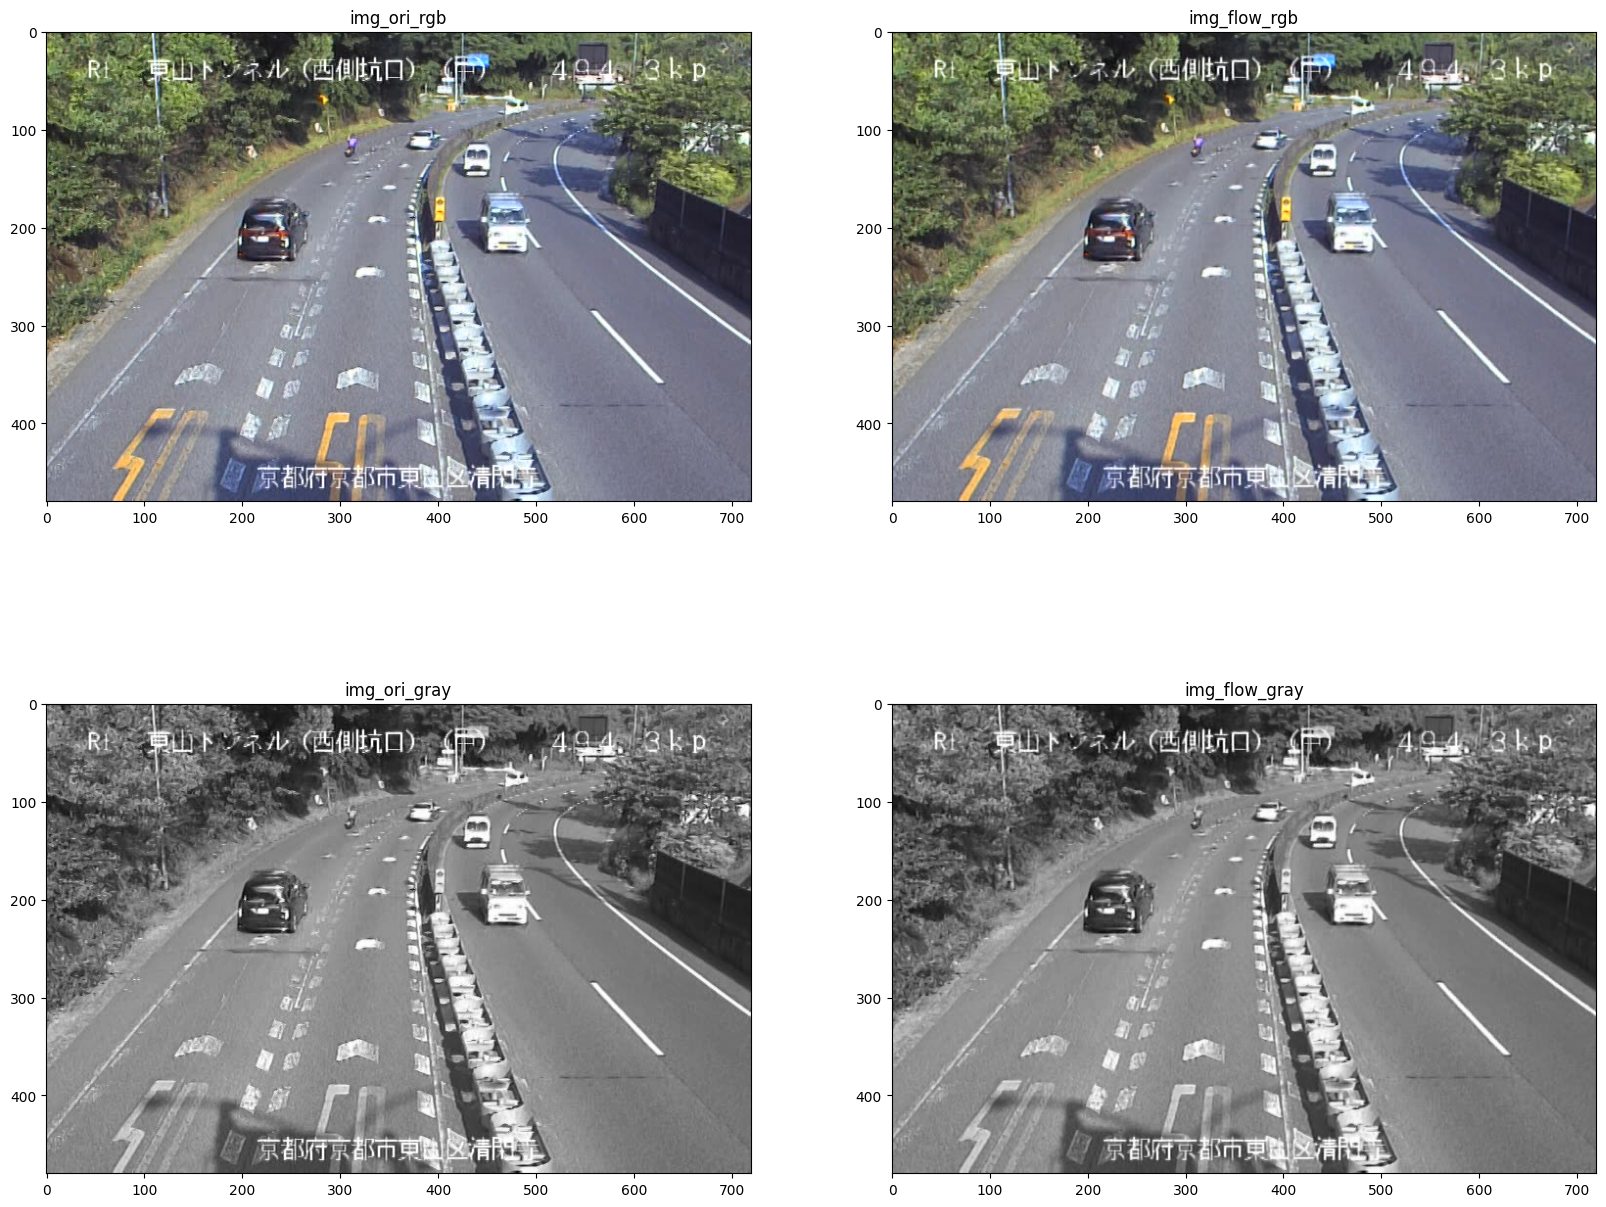

In [32]:
def tensor_to_cv(tensor):
    """将PyTorch Tensor转换为OpenCV图像格式
    注意：这里假设输入Tensor的通道顺序与cv2.imread读取结果一致（即BGR）。
    """
    # GPU Tensor -> CPU Tensor -> Numpy -> 通道顺序调整 -> 数值范围调整
    img = tensor.squeeze(0).detach().cpu()  # (C, H, W)
    img = img.permute(1, 2, 0).numpy()        # (H, W, C)
    img = (img * 255).clip(0, 255).astype(np.uint8)
    return img  # 保持BGR，不再转换


# フレームの読み込み
img_ori = cv2.imread('10.240.8.12C00061-20220519063947_0002.jpg')
img_ori = transforms.ToTensor()(img_ori)  
img_ori = img_ori.unsqueeze(0).cuda()
img_flow = flow_warp(img_ori, mask[13][1].permute(0,2,3,1), interpolation='bilinear', padding_mode='border')

# 原始图像转换
img_ori = tensor_to_cv(img_ori)

# 形变图像转换
img_flow = tensor_to_cv(img_flow)

# グレースケール化
img_ori_gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
img_flow_gray = cv2.cvtColor(img_flow, cv2.COLOR_BGR2GRAY)

# 表示
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
img_ori_rgb = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
axs[0, 0].set_title('img_ori_rgb')
axs[0, 0].imshow(img_ori_rgb)
img_flow_rgb = cv2.cvtColor(img_flow, cv2.COLOR_BGR2RGB)
axs[0, 1].set_title('img_flow_rgb')
axs[0, 1].imshow(img_flow_rgb)
axs[1, 0].set_title('img_ori_gray')
axs[1, 0].imshow(img_ori_gray, cmap='gray')
axs[1, 1].set_title('img_flow_gray')
axs[1, 1].imshow(img_flow_gray, cmap='gray')

plt.show()


u: (48, 72) v: (48, 72) x: (72,) y: (48,)


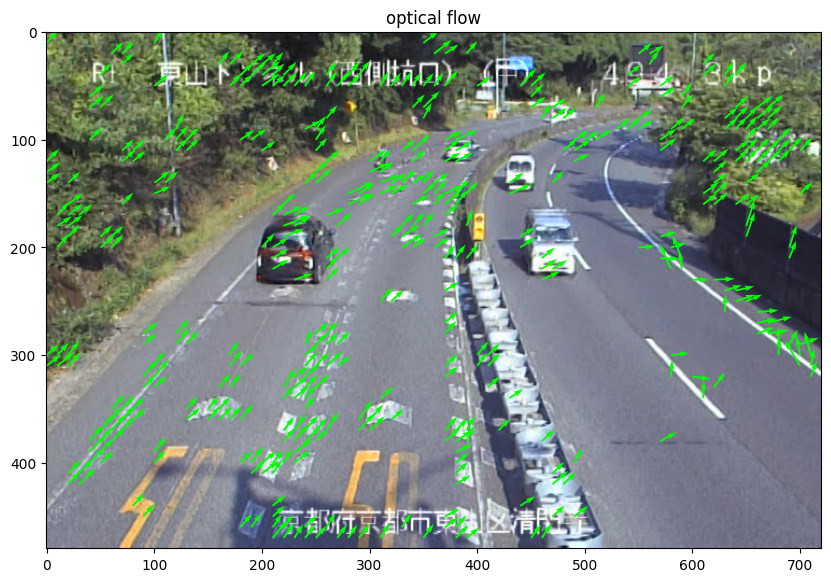

In [34]:
flow = cv2.calcOpticalFlowFarneback(img_ori_gray, img_flow_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('optical flow')
ax.imshow(img_flow_rgb)
x, y, u, v = flow_vector(flow=flow, spacing=10, margin=0, minlength=0.3)
print("u:", u.shape, "v:", v.shape, "x:", x.shape, "y:", y.shape)
ax.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=10, color=[0.0, 1.0, 0.0])

plt.show()
